# Facial Mask Detection Using Convolutional Neural Network Model using TensorFlow and Keras : An approach to reduce risk of Coronavirus spread

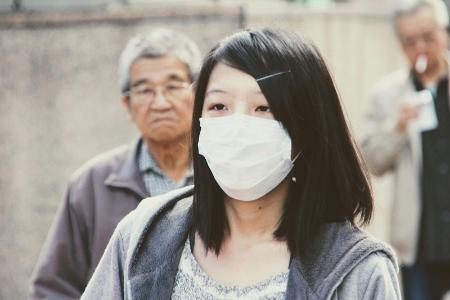
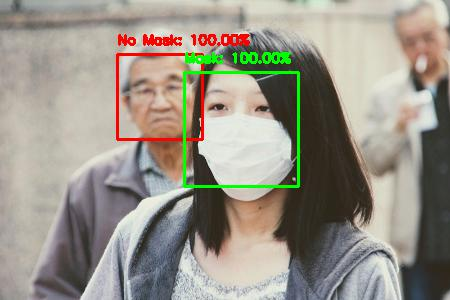

# The Steps of the notebook:

### 1. Importing the required Libraries
### 2. Preparing the images
### 3. Initializing the image generator for data augmentation
### 4. Splitting the data into train and test
### 5. Constructing the model using Transfer Learning by importing the weights of MobileNetV2
### 6. Training the model
### 7. Predicting and Evaluating the model
### 8. Face Detection phase using HaarCascade algorithm to test the model on input image
### 9. Testing the model on an input image

## 1. Importing the required Libraries

In [1]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout,Flatten,Dense,Input,AveragePooling2D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

### In this notebook I used the dataset from [Karan-Malik repository](https://github.com/Karan-Malik/FaceMaskDetector/tree/master/train) 

In [2]:
# cloning the repository where we find the training images
!git clone https://github.com/Karan-Malik/FaceMaskDetector

Cloning into 'FaceMaskDetector'...
remote: Enumerating objects: 1540, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 1540 (delta 42), reused 74 (delta 32), pack-reused 1454
Receiving objects: 100% (1540/1540), 84.40 MiB | 44.30 MiB/s, done.
Resolving deltas: 100% (59/59), done.


## 2. Preparing the images

In [3]:
# initializing the path of with mask and without mask images folders
with_mask_path = "/content/FaceMaskDetector/train/with_mask"
without_mask_path = "/content/FaceMaskDetector/train/without_mask"

In [4]:
# looping over the the images in the with mask folder to be in the same format name for later processing 
for i,image in enumerate(os.listdir(with_mask_path)):
  new_name = "with_mask "+str(i)+".jpg"
  os.rename(with_mask_path+"/"+image, with_mask_path+"/"+new_name)

print("The number of with-mask images is: ",len(os.listdir(with_mask_path)))
print("The names of 5 samples: ",os.listdir(with_mask_path)[:5])

The number of with-mask images is:  658
The names of 5 samples:  ['with_mask 126.jpg', 'with_mask 533.jpg', 'with_mask 429.jpg', 'with_mask 371.jpg', 'with_mask 554.jpg']


In [5]:
# looping over the the images in the without mask folder to be in the same format name for later processing 
for i,image in enumerate(os.listdir(without_mask_path)):
  new_name = "without_mask "+str(i)+".jpg"
  os.rename(without_mask_path+"/"+image, without_mask_path+"/"+new_name)

print("The number of without-mask images is: ",len(os.listdir(without_mask_path)))
print("The names of 5 samples: ",os.listdir(without_mask_path)[:5])

The number of without-mask images is:  656
The names of 5 samples:  ['without_mask 31.jpg', 'without_mask 498.jpg', 'without_mask 281.jpg', 'without_mask 441.jpg', 'without_mask 528.jpg']


In [6]:
# initializing empty lists to store the images and the labels after being processed
data = []
labels = []

# looping over the with mask and without mask images to process the images and extracting the labels
for imagePath in os.listdir(with_mask_path):
  # load the input image and resizing it to be 224x224
  image = load_img(with_mask_path+"/"+imagePath, target_size=(224, 224))
  # converting the image to numpy array
  image = img_to_array(image)
  image = preprocess_input(image)
  # appending the image after being preprocessed into the data list
  data.append(image)
  # appending the label of the image after extracting it from the image name
  labels.append(imagePath.split()[-2])

for imagePath in os.listdir(without_mask_path):
  
  # load the input image and resizing it to be 224x224
  image = load_img(without_mask_path+"/"+imagePath, target_size=(224, 224))
  # converting the image to numpy array
  image = img_to_array(image)
  image = preprocess_input(image)
  # appending the image after being preprocessed into the data list
  data.append(image)
  # # appending the label of the image after extracting it from the image name
  labels.append(imagePath.split()[-2])

# convering the data and labels lists to arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# shuffling the to arrays 
shuffler = np.random.permutation(len(labels))
data = data[shuffler]
labels = labels[shuffler]

In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

## 3. Initializing the image generator for data augmentation

In [8]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## 4. Splitting the data into train and test

In [9]:
# partition the data into training and testing splits using 80% of
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

## 5. Constructing the model using Transfer Learning by importing the weights of MobileNetV2 (builtin Model in tensorflow framework which pre-trained on imgenet dataset which consists of 1000 classes)

    - Transfer Learning is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task.

    - To put it simply—a model trained on one task is repurposed on a second, related task as an optimization that allows rapid progress when modeling the second task.

    -  So here in our task we ignore the last 1000 class layer and replace it with a new few layers to be trained on our dataset

    

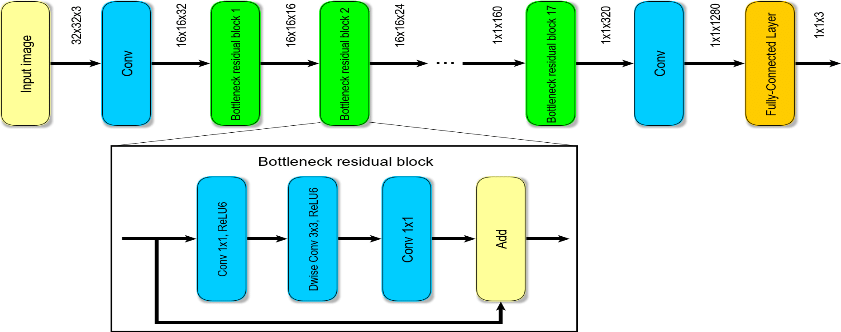

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model 
# this will be the final model we will train our data
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# initialize the initial learning rate, number of epochs and batch size
learning_rate = 1e-4
epochs = 20
batch_size = 32
# compile our model using Adam optimizer and choosing binary_crossentropy as loss function
opt = Adam(learning_rate=learning_rate, decay=learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## 6. Training the model

In [12]:
# training the head of the network
history = model.fit(
	aug.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

Epoch 1/20
32/32 [==============================] - 24s 371ms/step - loss: 0.6573 - accuracy: 0.6624 - val_loss: 0.3374 - val_accuracy: 0.9696
Epoch 2/20
32/32 [==============================] - 11s 334ms/step - loss: 0.2967 - accuracy: 0.9362 - val_loss: 0.1608 - val_accuracy: 0.9848
Epoch 3/20
32/32 [==============================] - 11s 330ms/step - loss: 0.1815 - accuracy: 0.9735 - val_loss: 0.1036 - val_accuracy: 0.9848
Epoch 4/20
32/32 [==============================] - 11s 359ms/step - loss: 0.1269 - accuracy: 0.9774 - val_loss: 0.0754 - val_accuracy: 0.9886
Epoch 5/20
32/32 [==============================] - 11s 335ms/step - loss: 0.0939 - accuracy: 0.9863 - val_loss: 0.0590 - val_accuracy: 0.9848
Epoch 6/20
32/32 [==============================] - 11s 336ms/step - loss: 0.0759 - accuracy: 0.9892 - val_loss: 0.0501 - val_accuracy: 0.9848
Epoch 7/20
32/32 [==============================] - 11s 336ms/step - loss: 0.0647 - accuracy: 0.9863 - val_loss: 0.0434 - val_accuracy: 0.9848

In [13]:
#from here you can save the model (weights) for later use
model_path = "mask_detector.model"
model.save(model_path, save_format="h5")

## 7. Predicting and Evaluating the model

In [14]:
# make predictions on the testing set
predictions = model.predict(testX)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predictions = np.argmax(predictions, axis=1)
# printing the confusion matrix and accuracy 
print("accuracy_score: ",accuracy_score(testY.argmax(axis=1), predictions))
print("----------------")
print("confusion_matrix:\n",confusion_matrix(testY.argmax(axis=1), predictions))

accuracy_score:  0.9923954372623575
----------------
confusion_matrix:
 [[131   1]
 [  1 130]]


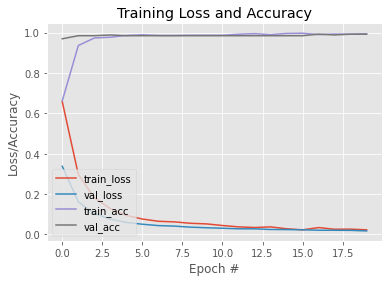

In [15]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# saving the figure of accuracy and loss
plot_path = "plot.png"
plt.savefig(plot_path)

In [16]:
# cloning the repository of this project to load the test images and the model if needed
!git clone https://github.com/MarwanMohamed95/Face_Mask_Detector

Cloning into 'Face_Mask_Detector'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [17]:
# uncomment this cells if you want to load the model again 
# in case you reopen the notebook instead of running all the cells above for training the model
#model_path = "/content/Face_Mask_Detector/mask_detector.model"
#model = load_model(model_path)

## 8. Face Detection phase using HaarCascade algorithm to test the model on input image

    - Haar Cascade classifiers are an effective way for object detection. This method was proposed by Paul Viola and Michael Jones in their paper Rapid Object Detection using a Boosted Cascade of Simple Features .Haar Cascade is a machine learning-based approach where a lot of positive and negative images are used to train the classifier. 

In [18]:
# load in haar cascade face detector from opencv
haar_cascade_file = cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(haar_cascade_file)

## 9. Testing the model on an input image
    - First we apply the HaarCascade algorithm to detect the faces in the input image
    - Second we predict this face by the trained model to detect whether the person wears the mask or not

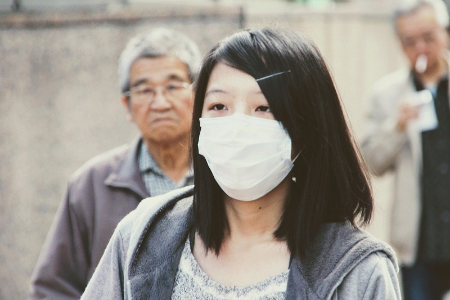

In [19]:
# loading the image
image_path = "/content/Face_Mask_Detector/Test1.jpg"
image = cv2.imread(image_path)
# converting from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# extracing the height and width of the image
(H,W) = image.shape[:2]
# resizing the image by keeping the same ratio between width and height
height = 300
width = int(height*W/H)
image = cv2.resize(image,(width,height))
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [20]:
# convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
# run the detector on the grayscale image
faces = face_cascade.detectMultiScale(gray)

In [21]:
# print out the detections found
print ('We found ' + str(len(faces)) + ' faces in this image')
print ("Their coordinates and lengths/widths are as follows")
print ('=============================')
print (faces)

We found 2 faces in this image
Their coordinates and lengths/widths are as follows
[[117  54  85  85]
 [184  72 114 114]]


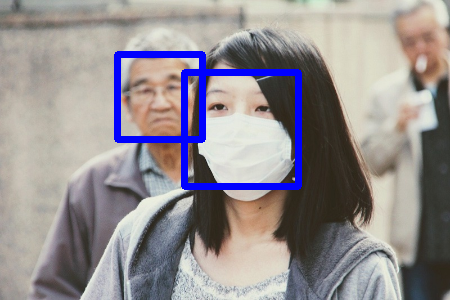

In [22]:
img_with_detections = np.copy(image)   # make a copy of the original image to plot rectangle detections ontop of

# loop over our detections and draw their corresponding boxes on top the image
for (x,y,w,h) in faces:
    # draw next detection as a blue rectangle on top of the image.  
    cv2.rectangle(img_with_detections,(x,y),(x+w,y+h),(0,0,255),5)  

cv2_imshow(cv2.cvtColor(img_with_detections, cv2.COLOR_BGR2RGB))
# saving the image
#img_with_detections = Image.fromarray(img_with_detections)
#img_with_detections.save('Test1Faces.jpg')

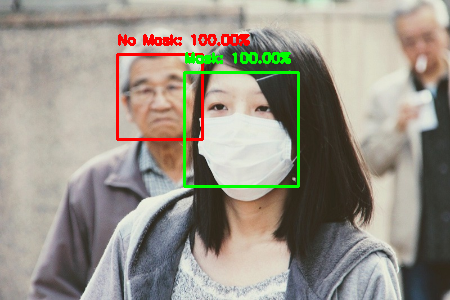

In [23]:
# looping over the face we found to capture them from the original image 
# to pass them to the model to test them if the face with mask or not
for x,y,w,h in faces:
  startX = x
  startY = y
  endX = x+w
  endY = y+h
  # slicing the face from the image
  face = image[startY:endY, startX:endX]
  # resizing the image for training and processing it
  face = cv2.resize(face, (224, 224))
  face = img_to_array(face)
  face = preprocess_input(face)
  face = np.expand_dims(face, axis=0)
  # predicting
  (mask, withoutMask) = model.predict(face)[0]

  # determine the class label and color we'll use to draw
	# the bounding box and text
  label = "Mask" if mask > withoutMask else "No Mask"
  color = (0, 255, 0) if label == "Mask" else (255, 0, 0)
	# include the probability in the label
  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
	# display the label and bounding box rectangle on the output frame
  cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# saving the image
#image = Image.fromarray(image)
#image.save('Test1Result.jpg')

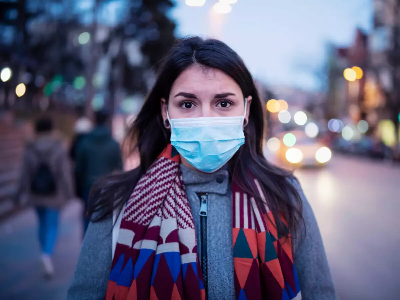

In [24]:
# loading the image
image_path = "/content/Face_Mask_Detector/Test2.webp"
image = cv2.imread(image_path)
# converting from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# extracing the height and width of the image
(H,W) = image.shape[:2]
# resizing the image by keeping the same ratio between width and height
height = 300
width = int(height*W/H)
image = cv2.resize(image,(width,height))
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [25]:
# convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
# run the detector on the grayscale image
faces = face_cascade.detectMultiScale(gray)

In [26]:
# print out the detections found
print ('We found ' + str(len(faces)) + ' faces in this image')
print ("Their coordinates and lengths/widths are as follows")
print ('=============================')
print (faces)

We found 1 faces in this image
Their coordinates and lengths/widths are as follows
[[154  66 101 101]]


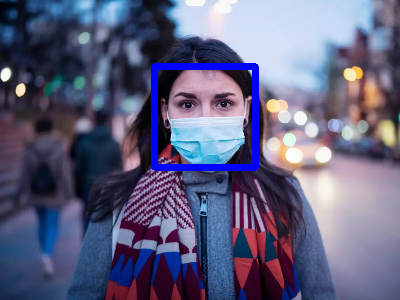

In [27]:
img_with_detections = np.copy(image)   # make a copy of the original image to plot rectangle detections ontop of

# loop over our detections and draw their corresponding boxes on top the image
for (x,y,w,h) in faces:
    # draw next detection as a blue rectangle on top of the image.  
    cv2.rectangle(img_with_detections,(x,y),(x+w,y+h),(0,0,255),5)  

cv2_imshow(cv2.cvtColor(img_with_detections, cv2.COLOR_BGR2RGB))
# saving the image
#img_with_detections = Image.fromarray(img_with_detections)
#img_with_detections.save('Test2Faces.jpg')

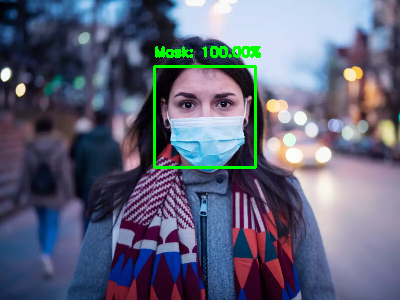

In [28]:
# looping over the face we found to capture them from the original image 
# to pass them to the model to test them if the face with mask or not
for x,y,w,h in faces:
  startX = x
  startY = y
  endX = x+w
  endY = y+h
  # slicing the face from the image
  face = image[startY:endY, startX:endX]
  # resizing the image for training and processing it
  face = cv2.resize(face, (224, 224))
  face = img_to_array(face)
  face = preprocess_input(face)
  face = np.expand_dims(face, axis=0)
  # predicting
  (mask, withoutMask) = model.predict(face)[0]

  # determine the class label and color we'll use to draw the bounding box and text
  label = "Mask" if mask > withoutMask else "No Mask"
  color = (0, 255, 0) if label == "Mask" else (255, 0, 0)
	# include the probability in the label
  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
	# display the label and bounding box rectangle on the output frame
  cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# saving the image
#image = Image.fromarray(image)
#image.save('Test2Result.jpg')

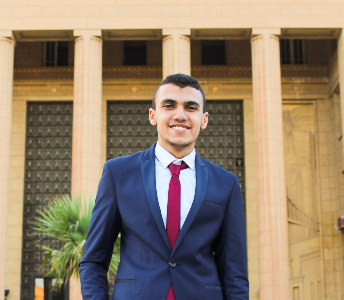

In [29]:
# loading the image
image_path = "/content/Face_Mask_Detector/Test3.jpg"
image = cv2.imread(image_path)
# converting from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# extracing the height and width of the image
(H,W) = image.shape[:2]
# resizing the image by keeping the same ratio between width and height
height = 300
width = int(height*W/H)
image = cv2.resize(image,(width,height))
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [30]:
# convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
# run the detector on the grayscale image
faces = face_cascade.detectMultiScale(gray,2,2)

In [31]:
# print out the detections found
print ('We found ' + str(len(faces)) + ' faces in this image')
print ("Their coordinates and lengths/widths are as follows")
print ('=============================')
print (faces)

We found 1 faces in this image
Their coordinates and lengths/widths are as follows
[[156  88  48  48]]


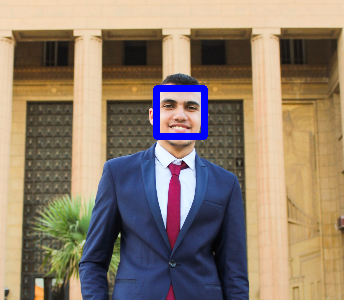

In [32]:
img_with_detections = np.copy(image)   # make a copy of the original image to plot rectangle detections ontop of

# loop over our detections and draw their corresponding boxes on top the image
for (x,y,w,h) in faces:
    # draw next detection as a blue rectangle on top of the image.  
    cv2.rectangle(img_with_detections,(x,y),(x+w,y+h),(0,0,255),5)  

cv2_imshow(cv2.cvtColor(img_with_detections, cv2.COLOR_BGR2RGB))

# saving the image
#img_with_detections = Image.fromarray(img_with_detections)
#img_with_detections.save('Test3Faces.jpg')

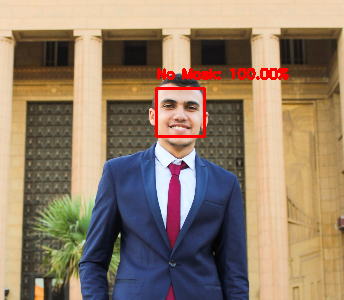

In [33]:
# looping over the face we found to capture them from the original image 
# to pass them to the model to test them if the face with mask or not
for x,y,w,h in faces:
  startX = x
  startY = y
  endX = x+w
  endY = y+h
  # slicing the face from the image
  face = image[startY:endY, startX:endX]
  # resizing the image for training and processing it
  face = cv2.resize(face, (224, 224))
  face = img_to_array(face)
  face = preprocess_input(face)
  face = np.expand_dims(face, axis=0)
  # predicting
  (mask, withoutMask) = model.predict(face)[0]

  # determine the class label and color we'll use to draw
	# the bounding box and text
  label = "Mask" if mask > withoutMask else "No Mask"
  color = (0, 255, 0) if label == "Mask" else (255, 0, 0)
	# include the probability in the label
  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
	# display the label and bounding box rectangle on the output frame
  cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# saving the image
#image = Image.fromarray(image)
#image.save('Test3Result.jpg')